In [1]:
import pandas as pd
#import geopandas as gpd
import numpy as np

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import os

import warnings
warnings.filterwarnings("ignore")

import datetime
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

from datetime import date, timedelta

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date       # as timedelta

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

In [5]:
twt_ods = read_OD_fn('TWT')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [6]:
lista_twt = []

for date in tqdm_notebook(target_days):
    lista_twt.append(twt_ods[date].loc['total','total'])
    
del twt_ods
    
lista_ine = []

for date in tqdm_notebook(target_days):
    lista_ine.append(ine_ods[date].loc['total','total'])
    
del ine_ods

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [7]:
df_twt = pd.DataFrame (lista_twt, columns = ['Viajes'], index= target_days)
df_ine = pd.DataFrame (lista_ine, columns = ['Viajes'], index= target_days)

In [8]:
df_twt.head()

,Viajes
2020-04-01,2375
2020-04-02,2450
2020-04-03,2503
2020-04-04,554
2020-04-05,1319


# Visualización de datos

In [9]:
print(df_twt.index.min())
print(df_ine.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [10]:
print(len(df_twt['2020']))

81


In [11]:
print(len(df_ine['2020']))

81


In [12]:
df_twt.describe()

,Viajes
count,81.000000
mean,2943.000000
std,887.069149
min,0.000000
25%,2363.000000
50%,2904.000000
75%,3629.000000
max,4738.000000


In [13]:
df_ine.describe()

,Viajes
count,8.100000e+01
mean,3.438222e+06
std,1.174931e+06
min,1.535886e+06
25%,2.488436e+06
50%,3.396402e+06
75%,4.445190e+06
max,5.519725e+06


In [14]:
meses = df_twt.resample('M').mean()
meses

,Viajes
2020-04-30,2157.500000
2020-05-31,3128.193548
2020-06-30,3834.200000


In [15]:
meses = df_ine.resample('M').mean()
meses

,Viajes
2020-04-30,2.356878e+06
2020-05-31,3.590722e+06
2020-06-30,4.823862e+06


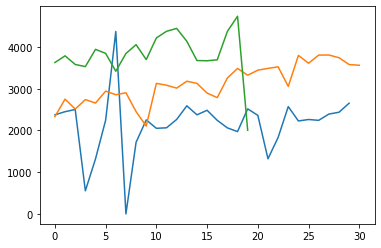

In [16]:
abril = df_twt['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df_twt['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df_twt['2020-06-01':'2020-06-20']
plt.plot(junio.values)

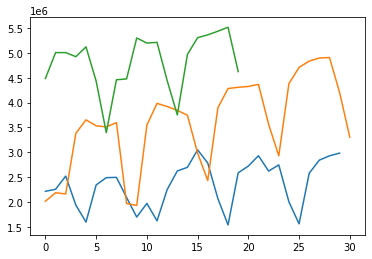

In [17]:
abril = df_ine['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df_ine['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df_ine['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [18]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

PASOS=7 #preguntar

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# cargamos el dataframe en la variable values
values_twt = df_twt.values
values_ine = df_ine.values

# convertimos los enteros en floats
values_twt = values_twt.astype('float32')
values_ine = values_ine.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
scaler = MinMaxScaler(feature_range=(-1, 1))
values_twt=values_twt.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
values_ine=values_ine.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled_twt = scaler.fit_transform(values_twt)
scaled_ine = scaler.fit_transform(values_ine)

# usamos la funcion definida previamente
reframed_twt = series_to_supervised(scaled_twt, PASOS, 1)
reframed_ine = series_to_supervised(scaled_ine, PASOS, 1)

#imprimimos los nuevos datos
reframed_twt.tail()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
76,0.712537,0.561418,0.780498,0.847615,0.876741,0.747151,0.551710,0.549599
77,0.561418,0.780498,0.847615,0.876741,0.747151,0.551710,0.549599,0.559308
78,0.780498,0.847615,0.876741,0.747151,0.551710,0.549599,0.559308,0.846771
79,0.847615,0.876741,0.747151,0.551710,0.549599,0.559308,0.846771,1.000000
80,0.876741,0.747151,0.551710,0.549599,0.559308,0.846771,1.000000,-0.153229


In [19]:
#cambiamos el nombre de las columnas
reframed_ine.columns = ['var2(t-7)', 'var2(t-6)', 'var2(t-5)', 'var2(t-4)', 'var2(t-3)', 'var2(t-2)', 'var2(t-1)', 'var2(t)']
reframed_ine.tail()

,var2(t-7),var2(t-6),var2(t-5),var2(t-4),var2(t-3),var2(t-2),var2(t-1),var2(t)
76,0.477061,0.891413,0.839957,0.847171,0.460553,0.113062,0.725623,0.894152
77,0.891413,0.839957,0.847171,0.460553,0.113062,0.725623,0.894152,0.923149
78,0.839957,0.847171,0.460553,0.113062,0.725623,0.894152,0.923149,0.959687
79,0.847171,0.460553,0.113062,0.725623,0.894152,0.923149,0.959687,1.000000
80,0.460553,0.113062,0.725623,0.894152,0.923149,0.959687,1.000000,0.551599


In [20]:
#unimos los datos del ine con los de twitter
reframed = pd.concat([reframed_twt.iloc[:, 0], reframed_ine.iloc[:, 0]], axis=1)

for i in range(6):
    reframed = pd.concat([reframed, reframed_twt.iloc[:, i+1]], axis=1)
    reframed = pd.concat([reframed, reframed_ine.iloc[:, i+1]], axis=1)
    
reframed = pd.concat([reframed, reframed_ine.iloc[:, 7]], axis=1)

reframed.tail()

,var1(t-7),var2(t-7),var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var2(t)
76,0.712537,0.477061,0.561418,0.891413,0.780498,0.839957,0.847615,0.847171,0.876741,0.460553,0.747151,0.113062,0.551710,0.725623,0.894152
77,0.561418,0.891413,0.780498,0.839957,0.847615,0.847171,0.876741,0.460553,0.747151,0.113062,0.551710,0.725623,0.549599,0.894152,0.923149
78,0.780498,0.839957,0.847615,0.847171,0.876741,0.460553,0.747151,0.113062,0.551710,0.725623,0.549599,0.894152,0.559308,0.923149,0.959687
79,0.847615,0.847171,0.876741,0.460553,0.747151,0.113062,0.551710,0.725623,0.549599,0.894152,0.559308,0.923149,0.846771,0.959687,1.000000
80,0.876741,0.460553,0.747151,0.113062,0.551710,0.725623,0.549599,0.894152,0.559308,0.923149,0.846771,0.959687,1.000000,1.000000,0.551599


# Dividimos los datos en sets de entrenamiento y validacion

In [21]:
#dividimos nuestro valores entre sets de entrenamiento y de test
values = reframed.values
n_train_days = 75 - (5+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features] - preguntar
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(63, 1, 14) (63,) (11, 1, 14) (11,)


# Creamos la red neuronal

In [22]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS*2),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(4, activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [23]:
EPOCHS=80

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 7)              105       
_________________________________________________________________
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 142
Trainable params: 142
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
9/9 [==============================] - 3s 243ms/step - loss: 0.9975 - mse: 1.1664 - val_loss: 1.4018 - val_mse: 2.0448
Epoch 2/80
9/9 [==============================] - 0s 11ms/step - loss: 0.9009 - mse: 1.0018 - val_loss: 1.2688 - val_mse: 1.69

# Visualizamos resultados

In [24]:
results=model.predict(x_val)
print(len(results))

11


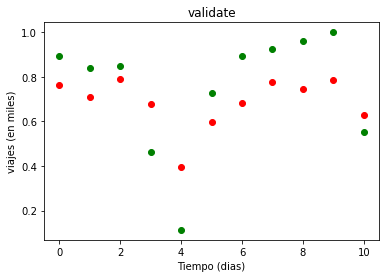

In [25]:
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

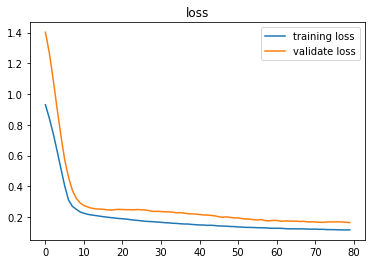

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

# Prediccion a futuro

In [27]:
# usaremos los 14 ultimos dias del confinamiento en junio para predecir como habrian sido los dias del 21 al 27 en caso de que
# el confinamiento se hubiese alargado por una semana mas

ultimosDias_twt = df_twt['2020-6-7':'2020-6-20']
ultimosDias_ine = df_ine['2020-6-7':'2020-6-20']
ultimosDias_twt

,Viajes
2020-06-07,3420
2020-06-08,3845
2020-06-09,4057
2020-06-10,3699
2020-06-11,4218
2020-06-12,4377
2020-06-13,4446
2020-06-14,4139
2020-06-15,3676
2020-06-16,3671


# Preparamos los datos para el test

In [28]:
# cargamos el dataframe en la variable values
values_twt = ultimosDias_twt.values
values_ine = ultimosDias_ine.values

# convertimos los enteros en floats
values_twt = values_twt.astype('float32')
values_ine = values_ine.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
values_twt =values_twt.reshape(-1, 1)
scaled_twt = scaler.fit_transform(values_twt)
values_ine =values_ine.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled_ine = scaler.fit_transform(values_ine)

# usamos la funcion definida previamente
reframed_twt = series_to_supervised(scaled_twt, PASOS, 1)
reframed_ine = series_to_supervised(scaled_ine, PASOS, 1)

# eliminamos la ultima columna pues es parte de lo que queremos hayar
reframed_twt.drop(reframed_twt.columns[[7]], inplace=True, axis=1)
reframed_ine.drop(reframed_ine.columns[[7]], inplace=True, axis=1)

#unimos los dataframes
reframed_ine.columns = ['var2(t-7)', 'var2(t-6)', 'var2(t-5)', 'var2(t-4)', 'var2(t-3)', 'var2(t-2)', 'var2(t-1)']
reframed = pd.concat([reframed_twt.iloc[:, 0], reframed_ine.iloc[:, 0]], axis=1)

for i in range(6):
    reframed = pd.concat([reframed, reframed_twt.iloc[:, i+1]], axis=1)
    reframed = pd.concat([reframed, reframed_ine.iloc[:, i+1]], axis=1)

#mostramos el set de entrenamiento
reframed.head(7)

,var1(t-7),var2(t-7),var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1)
7,0.035139,-1.000000,0.346267,0.002901,0.501464,0.018846,0.239385,0.796266,0.619327,0.699721,0.735725,0.713258,0.786237,-0.012126
8,0.346267,0.002901,0.501464,0.018846,0.239385,0.796266,0.619327,0.699721,0.735725,0.713258,0.786237,-0.012126,0.561494,-0.664099
9,0.501464,0.018846,0.239385,0.796266,0.619327,0.699721,0.735725,0.713258,0.786237,-0.012126,0.561494,-0.664099,0.222548,0.485206
10,0.239385,0.796266,0.619327,0.699721,0.735725,0.713258,0.786237,-0.012126,0.561494,-0.664099,0.222548,0.485206,0.218887,0.801405
11,0.619327,0.699721,0.735725,0.713258,0.786237,-0.012126,0.561494,-0.664099,0.222548,0.485206,0.218887,0.801405,0.235725,0.855810
12,0.735725,0.713258,0.786237,-0.012126,0.561494,-0.664099,0.222548,0.485206,0.218887,0.801405,0.235725,0.855810,0.734261,0.924364
13,0.786237,-0.012126,0.561494,-0.664099,0.222548,0.485206,0.218887,0.801405,0.235725,0.855810,0.734261,0.924364,1.000000,1.000000


In [29]:
values = reframed.values

#tomamos los valores para realizar el test
x_test = values[6:, :]

# reshape input to be 3D [samples, timesteps, features] - preguntar
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 14)


array([[[ 0.78623724, -0.01212597,  0.56149364, -0.6640985 ,
          0.22254777,  0.48520565,  0.21888733,  0.80140543,
          0.23572493,  0.8558097 ,  0.7342608 ,  0.9243636 ,
          1.        ,  1.        ]]], dtype=float32)

In [30]:
#definimos la funcion para realizar el desplazamiento que se hara en el array cada prediccion pues para hacer
#la siguiente prediccion eliminamos el dia mas antiguo, desplazamos un lugar el resto de dias y añadimos el ultimo dia que
#se ha predecido, esto es por que para predecir un dia se usan los 7 dias previos

def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

# Predicciones para la proxima semana

In [31]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[ 0.78623724 -0.01212597  0.56149364 -0.6640985   0.22254777
    0.48520565  0.21888733  0.80140543  0.23572493  0.8558097
    0.7342608   0.9243636   1.          1.        ]]]
[[[-0.01212597  0.56149364 -0.6640985   0.22254777  0.48520565
    0.21888733  0.80140543  0.23572493  0.8558097   0.7342608
    0.9243636   1.          1.          0.20918407]]]
[[[ 0.56149364 -0.6640985   0.22254777  0.48520565  0.21888733
    0.80140543  0.23572493  0.8558097   0.7342608   0.9243636
    1.          1.          0.20918407  0.7893052 ]]]
[[[-0.6640985   0.22254777  0.48520565  0.21888733  0.80140543
    0.23572493  0.8558097   0.7342608   0.9243636   1.
    1.          0.20918407  0.7893052  -0.21598375]]]
[[[ 0.22254777  0.48520565  0.21888733  0.80140543  0.23572493
    0.8558097   0.7342608   0.9243636   1.          1.
    0.20918407  0.7893052  -0.21598375  0.7524735 ]]]
[[[ 0.48520565  0.21888733  0.80140543  0.23572493  0.8558097
    0.7342608   0.9243636   1.          1.          0.209

# Re-Convertimos los resultados

In [32]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([0.20918407], dtype=float32), array([0.7893052], dtype=float32), array([-0.21598375], dtype=float32), array([0.7524735], dtype=float32), array([0.32157692], dtype=float32), array([0.67394], dtype=float32), array([0.57819116], dtype=float32)]


array([[4680146.37413286],
       [5296038.64252398],
       [4228762.0869683 ],
       [5256935.80686511],
       [4799469.54085401],
       [5173559.84683124],
       [5071906.99053983]])

# Visualizamos el pronostico

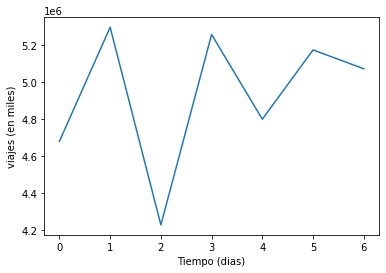

In [33]:
#prediccion = pd.DataFrame(inverted)
#prediccion.columns = ['pronostico']
#plt.xlabel("Tiempo (dias)", fontsize = 10)
#plt.ylabel("viajes (en miles)", fontsize = 10)
#prediccion.plot()
plt.plot(pd.DataFrame(inverted))
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

# Prediccion con datos actuales

In [34]:
# usaremos 14 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error
Dias_twt = df_twt['2020-5-11':'2020-5-24']
Dias_ine = df_ine['2020-5-11':'2020-5-24']
Dias_twt

,Viajes
2020-05-11,3128
2020-05-12,3085
2020-05-13,3015
2020-05-14,3181
2020-05-15,3129
2020-05-16,2896
2020-05-17,2787
2020-05-18,3258
2020-05-19,3487
2020-05-20,3324


# Preparamos los datos para el test

In [35]:
# cargamos el dataframe en la variable values
values_twt = Dias_twt.values
values_ine = Dias_ine.values

# convertimos los enteros en floats
values_twt = values_twt.astype('float32')
values_ine = values_ine.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
values_twt =values_twt.reshape(-1, 1)
scaled_twt = scaler.fit_transform(values_twt)
values_ine =values_ine.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled_ine = scaler.fit_transform(values_ine)

# usamos la funcion definida previamente
reframed_twt = series_to_supervised(scaled_twt, PASOS, 1)
reframed_ine = series_to_supervised(scaled_ine, PASOS, 1)

# eliminamos la ultima columna pues es parte de lo que queremos hayar
reframed_twt.drop(reframed_twt.columns[[7]], inplace=True, axis=1)
reframed_ine.drop(reframed_ine.columns[[7]], inplace=True, axis=1)

#unimos los dataframes
reframed_ine.columns = ['var2(t-7)', 'var2(t-6)', 'var2(t-5)', 'var2(t-4)', 'var2(t-3)', 'var2(t-2)', 'var2(t-1)']
reframed = pd.concat([reframed_twt.iloc[:, 0], reframed_ine.iloc[:, 0]], axis=1)

for i in range(6):
    reframed = pd.concat([reframed, reframed_twt.iloc[:, i+1]], axis=1)
    reframed = pd.concat([reframed, reframed_ine.iloc[:, i+1]], axis=1)

#mostramos el set de entrenamiento
reframed.head(7)

,var1(t-7),var2(t-7),var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1)
7,-0.077132,0.150527,-0.193505,0.604381,-0.382951,0.539155,0.066305,0.459777,-0.074426,0.356781,-0.705008,-0.429630,-1.000000,-1.000000
8,-0.193505,0.604381,-0.382951,0.539155,0.066305,0.459777,-0.074426,0.356781,-0.705008,-0.429630,-1.000000,-1.000000,0.274695,0.512966
9,-0.382951,0.539155,0.066305,0.459777,-0.074426,0.356781,-0.705008,-0.429630,-1.000000,-1.000000,0.274695,0.512966,0.894451,0.912932
10,0.066305,0.459777,-0.074426,0.356781,-0.705008,-0.429630,-1.000000,-1.000000,0.274695,0.512966,0.894451,0.912932,0.453315,0.938927
11,-0.074426,0.356781,-0.705008,-0.429630,-1.000000,-1.000000,0.274695,0.512966,0.894451,0.912932,0.453315,0.938927,0.780785,0.955663
12,-0.705008,-0.429630,-1.000000,-1.000000,0.274695,0.512966,0.894451,0.912932,0.453315,0.938927,0.780785,0.955663,0.897158,1.000000
13,-1.000000,-1.000000,0.274695,0.512966,0.894451,0.912932,0.453315,0.938927,0.780785,0.955663,0.897158,1.000000,0.999999,0.169306


In [36]:
values = reframed.values

#tomamos los valores para realizar el test
x_test = values[6:, :]

# reshape input to be 3D [samples, timesteps, features] - preguntar
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 14)


array([[[-1.0000005 , -1.        ,  0.2746954 ,  0.51296616,
          0.89445114,  0.9129319 ,  0.45331478,  0.9389267 ,
          0.7807846 ,  0.9556627 ,  0.89715767,  1.        ,
          0.99999905,  0.16930556]]], dtype=float32)

In [37]:
#en la linea 24 definimos la funcion para realizar el desplazamiento que se hara en el array cada prediccion pues para hacer
#la siguiente prediccion eliminamos el dia mas antiguo, desplazamos un lugar el resto de dias y añadimos el ultimo dia que
#se ha predecido, esto es por que para predecir un dia se usan los 7 dias previos, y que usaremos a continuación

# Realizamos la prediccion 

In [38]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-1.0000005  -1.          0.2746954   0.51296616  0.89445114
    0.9129319   0.45331478  0.9389267   0.7807846   0.9556627
    0.89715767  1.          0.99999905  0.16930556]]]
[[[-1.          0.2746954   0.51296616  0.89445114  0.9129319
    0.45331478  0.9389267   0.7807846   0.9556627   0.89715767
    1.          0.99999905  0.16930556 -0.25746387]]]
[[[ 0.2746954   0.51296616  0.89445114  0.9129319   0.45331478
    0.9389267   0.7807846   0.9556627   0.89715767  1.
    0.99999905  0.16930556 -0.25746387  0.5887383 ]]]
[[[ 0.51296616  0.89445114  0.9129319   0.45331478  0.9389267
    0.7807846   0.9556627   0.89715767  1.          0.99999905
    0.16930556 -0.25746387  0.5887383   0.5358879 ]]]
[[[ 0.89445114  0.9129319   0.45331478  0.9389267   0.7807846
    0.9556627   0.89715767  1.          0.99999905  0.16930556
   -0.25746387  0.5887383   0.5358879   0.74546534]]]
[[[ 0.9129319   0.45331478  0.9389267   0.7807846   0.9556627
    0.89715767  1.          0.99999905  0.16930556

# Re-Convertimos los resultados

In [39]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)
inverted

[array([-0.25746387], dtype=float32), array([0.5887383], dtype=float32), array([0.5358879], dtype=float32), array([0.74546534], dtype=float32), array([0.6781609], dtype=float32), array([0.5888618], dtype=float32), array([0.7891078], dtype=float32)]


array([[3150116],
       [3970224],
       [3919003],
       [4122118],
       [4056889],
       [3970343],
       [4164414]])

# Visualizamos el pronostico

<AxesSubplot:>

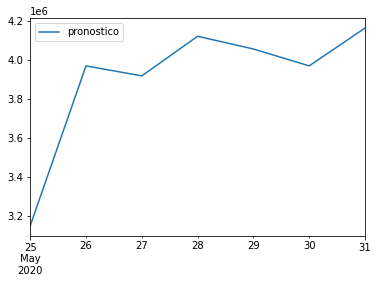

In [40]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [41]:
datosReales = df_ine['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']
compara

,real,prediccion
2020-05-25,4382232,3150116
2020-05-26,4709433,3970224
2020-05-27,4837770,3919003
2020-05-28,4898946,4122118
2020-05-29,4909824,4056889
2020-05-30,4202334,3970343
2020-05-31,3305717,4164414


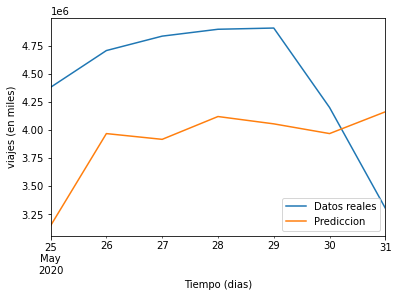

In [42]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [43]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(prediccion, datosReales)

801506.1428571428

In [44]:
from sklearn.metrics import mean_squared_error

mean_squared_error(prediccion, datosReales)

718687543017.8572